# 03 Classification
Classify weather patterns using features extracted by ViT+SCL model. 

In [1]:
import torch

import numpy as np
import scipy.io as sio

import pandas as pd
import datetime as dt
import xarray as xr

from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [2]:
root_dir = '/global/cfs/projectdirs/m1657/liuy351/TallTower/ContrastiveTransformer'


In [3]:
# feature_path = '../runs/transformer_embedding.s.e10b128.2001-2020.pt'
# time_idx_path = '../data/processed/preprocessed_data_time.2001-2020.csv'
# linkage_path = '../runs/linkage_metrix.s.e10b128.2001-2020.npy'
# clustering_label_path = '../clustering_linkage.s.e10b128.2001-2020.JJA.nc'

# feature_path = '../runs/transformer_embedding.s.e10b128.2001-2024.allmean.pt'
# time_idx_path = '../data/processed/preprocessed_data_time.2001-2024.allmean.csv'
# linkage_path = '../runs/linkage_metrix.s.e10b128.2001-2024.allmean.npy'
# clustering_label_path = '../runs/clustering_linkage.s.e10b128.2001-2024.JJA.allmean.nc'
# clustering_label_path = '../runs/clustering_linkage.s.e10b128.2001-2024.JJA.allmean.30dr12h.nc'
# clustering_label_path = '../runs/clustering_linkage.s.e10b128.2001-2024.allmean.nc'
# clustering_label_path = '../runs/clustering_linkage.s.e10b128.2014-2024.allmean.nc'

data_option = 'allmean'
model_option = '4patch'
cluster_option = 'ANN.r30d24h' # r30d - remove 30 day running mean, 24h - 24 hour running mean
# cluster_option = 'ANN.r30d24h' # r30d - remove 30 day running mean, 24h - 24 hour running mean
feature_path = f'../runs/transformer_embedding.s.e10b128.2001-2024.{data_option}.{model_option}.pt'
time_idx_path = f'../data/processed/preprocessed_data_time.2001-2024.{data_option}.csv'
linkage_path = f'../runs/linkage_metrix.s.e10b128.2014-2024.{data_option}.{model_option}.{cluster_option}.npy'
clustering_label_path = f'../runs/clustering_linkage.s.e10b128.2014-2024.{data_option}.{model_option}.{cluster_option}.nc'


In [4]:
# read features
feature = torch.load(feature_path, map_location=torch.device('cpu')).numpy()
feature.shape

(203776, 512)

In [5]:
time = pd.read_csv(time_idx_path, index_col=0).squeeze()
time = pd.to_datetime(time[:feature.shape[0]])
time.shape


(203776,)

In [6]:
feature = xr.DataArray(feature, dims=['time', 'feature'], coords=[time, np.arange(feature.shape[1])])
feature

<xarray.DataArray (time: 203776, feature: 512)> Size: 417MB
array([[ -1.7872903 ,  28.915867  , -48.958126  , ..., -24.493925  ,
         42.889877  , -54.15011   ],
       [  0.9807661 ,  31.858223  , -46.44183   , ..., -24.976019  ,
         49.112976  , -51.91771   ],
       [ -0.78695506,  32.186943  , -45.874218  , ..., -26.739325  ,
         41.159786  , -49.14099   ],
       ...,
       [  1.9232117 ,   1.2748909 , -32.081203  , ..., -30.040762  ,
        -22.15638   , -51.147694  ],
       [  4.7089243 ,  -3.2390313 , -32.307606  , ..., -29.82546   ,
        -22.414412  , -50.725323  ],
       [  6.8367715 ,  -3.8318539 , -32.487514  , ..., -26.442858  ,
        -19.88731   , -51.91446   ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2MB 2001-01-01 ... 2024-03-31T15:00:00
  * feature  (feature) int64 4kB 0 1 2 3 4 5 6 7 ... 505 506 507 508 509 510 511

In [7]:
feature = feature - feature.rolling(time=24*30, min_periods=2, center=True).mean()
feature = feature.rolling(time=24, min_periods=2, center=True).mean()
# feature = feature.rolling(time=12, min_periods=2, center=True).mean()


In [8]:
feature['time.month'].isin([6,7,8])

<xarray.DataArray 'month' (time: 203776)> Size: 204kB
array([False, False, False, ..., False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 2MB 2001-01-01 ... 2024-03-31T15:00:00

In [9]:
# xfeature = feature.sel(time=slice('2016-06-01', '2016-09-01'))

# xfeature = feature.sel(time=feature['time.month'].isin([6,7,8]))

xfeature = feature.sel(time=slice('2014-01-01', '2024-12-31'))

xfeature

<xarray.DataArray (time: 89824, feature: 512)> Size: 184MB
array([[ 6.1599312e+00, -7.6888819e+00, -1.7468929e-02, ...,
         3.7282941e+00, -7.5258017e+00,  3.9159775e+00],
       [ 6.0828967e+00, -7.5114760e+00,  1.7739329e-01, ...,
         3.8809621e+00, -7.6765137e+00,  4.1843486e+00],
       [ 6.0362258e+00, -7.2038965e+00,  4.0000948e-01, ...,
         4.0415974e+00, -7.7692528e+00,  4.5290594e+00],
       ...,
       [ 1.1579870e+00,  2.0214029e+01,  1.2665635e+00, ...,
        -1.1821350e+01, -2.8384434e+01, -3.1580429e+00],
       [ 1.5690496e+00,  2.0341673e+01,  1.2323756e+00, ...,
        -1.2182771e+01, -2.9578619e+01, -3.1521509e+00],
       [ 2.0451150e+00,  2.0612234e+01,  1.0743004e+00, ...,
        -1.2763170e+01, -3.0515913e+01, -3.3415637e+00]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 719kB 2014-01-01 ... 2024-03-31T15:00:00
  * feature  (feature) int64 4kB 0 1 2 3 4 5 6 7 ... 505 506 507 508 509 510 511

In [10]:
# Z = linkage(xfeature, 'ward')
# np.save(linkage_path, Z)

Z = np.load(linkage_path)


In [11]:
Z[0,:]

array([8.42080000e+04, 8.42090000e+04, 1.39872917e+00, 2.00000000e+00])

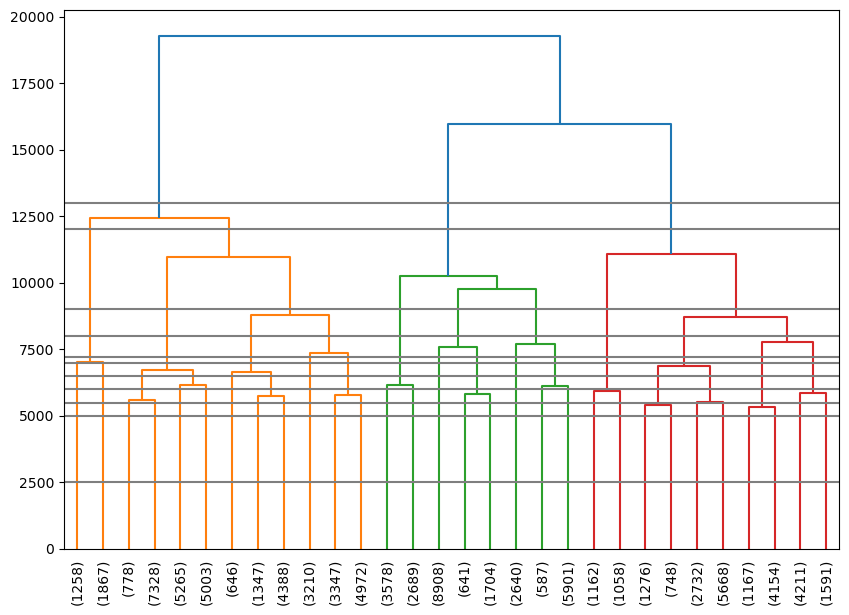

In [18]:
# thresholds = [500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 2000]
thresholds = [2500,5000,5500,6000,6500,7000,7200,8000,9000,12000,13000]
# thresholds = [15000,17500,20000,25000,28000,30000,35000]

fig, ax = plt.subplots(1,1, figsize=(10, 7))
labels = [f'Sample {i}' for i in range(xfeature.shape[0])]

tree = dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90, labels=labels, ax=ax)
# _ = dendrogram(Z, leaf_rotation=90, labels=labels, ax=ax)

for threshold in thresholds:
    ax.axhline(threshold, c='tab:gray')



In [19]:
output_labels = []
for threshold in thresholds:
    labels = fcluster(Z, t=threshold, criterion='distance')
    unique_labels = np.unique(labels)
    output_labels.append(labels)
    print(f"Number of clusters found: {len(unique_labels)} for {threshold}")
output_labels = np.stack(output_labels, axis=1)
output_labels = xr.DataArray(output_labels, dims=['time', 'threshold'], coords=[xfeature.time, thresholds], name='cluster')
output_labels.to_netcdf(clustering_label_path)

Number of clusters found: 153 for 2500
Number of clusters found: 33 for 5000
Number of clusters found: 28 for 5500
Number of clusters found: 21 for 6000
Number of clusters found: 18 for 6500
Number of clusters found: 15 for 7000
Number of clusters found: 14 for 7200
Number of clusters found: 10 for 8000
Number of clusters found: 8 for 9000
Number of clusters found: 4 for 12000
Number of clusters found: 3 for 13000


In [20]:
max_d1 = 6500
max_d2 = 12000

clusters1 = fcluster(Z, max_d1, criterion='distance')
clusters2 = fcluster(Z, max_d2, criterion='distance')

from collections import defaultdict

def get_cluster_dict(clusters):
    cluster_dict = defaultdict(list)
    for idx, cluster_id in enumerate(clusters):
        cluster_dict[cluster_id].append(idx)
    return cluster_dict

cluster_dict1 = get_cluster_dict(clusters1)
cluster_dict2 = get_cluster_dict(clusters2)

# print("Clusters for max_d1:")
# for cluster_id, indices in cluster_dict1.items():
#     print(f"Cluster {cluster_id}: {indices}")

# print("\nClusters for max_d2:")
# for cluster_id, indices in cluster_dict2.items():
#     print(f"Cluster {cluster_id}: {indices}")

def find_subclusters(cluster_dict1, cluster_dict2):
    result = defaultdict(list)
    for cluster_id2, indices2 in cluster_dict2.items():
        subclusters = set()
        for idx in indices2:
            for cluster_id1, indices1 in cluster_dict1.items():
                if idx in indices1:
                    subclusters.add(cluster_id1)
        result[cluster_id2] = list(subclusters)
    return result

subclusters = find_subclusters(cluster_dict1, cluster_dict2)

print("\nHigh level clusters and their low level subclusters:")
for cluster_id2, subclusters in subclusters.items():
    print(f"High level cluster {cluster_id2} contains low level clusters: {subclusters}")



High level clusters and their low level subclusters:
High level cluster 4 contains low level clusters: [14, 15, 16, 17, 18]
High level cluster 3 contains low level clusters: [9, 10, 11, 12, 13]
High level cluster 2 contains low level clusters: [3, 4, 5, 6, 7, 8]
High level cluster 1 contains low level clusters: [1, 2]


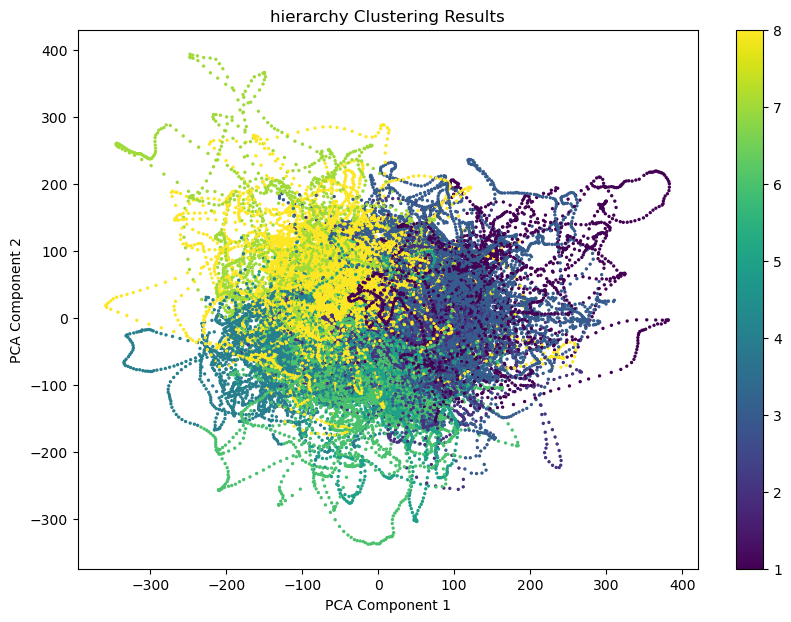

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(xfeature)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=output_labels.sel(threshold=9000), cmap='viridis', s=2)
plt.title("hierarchy Clustering Results")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

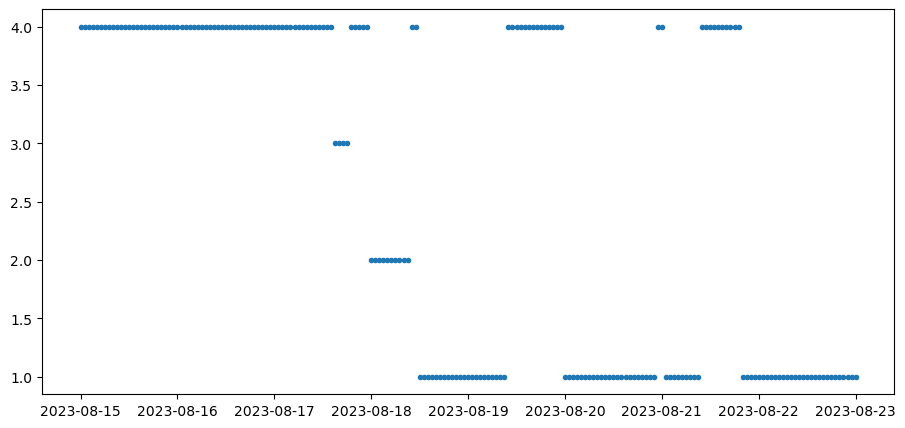

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(11,5))
_output_labels = output_labels.sel(time=slice('2023-08-15 00:00', '2023-08-23 00:00'))
ax.plot(_output_labels.time, _output_labels.sel(threshold=13000), ls='None', marker='.')


In [18]:
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None
output_labels.sel(threshold=11000).sel(time=slice('2016-08-01 00:00', '2016-08-30 00:00')).to_pandas()


time
2016-08-01 00:00:00    3
2016-08-01 01:00:00    3
2016-08-01 02:00:00    3
2016-08-01 03:00:00    3
2016-08-01 04:00:00    3
2016-08-01 05:00:00    1
2016-08-01 06:00:00    1
2016-08-01 07:00:00    1
2016-08-01 08:00:00    1
2016-08-01 09:00:00    1
2016-08-01 10:00:00    1
2016-08-01 11:00:00    1
2016-08-01 12:00:00    1
2016-08-01 13:00:00    1
2016-08-01 14:00:00    1
2016-08-01 15:00:00    1
2016-08-01 16:00:00    1
2016-08-01 17:00:00    1
2016-08-01 18:00:00    1
2016-08-01 19:00:00    1
2016-08-01 20:00:00    1
2016-08-01 21:00:00    1
2016-08-01 22:00:00    1
2016-08-01 23:00:00    1
2016-08-02 00:00:00    1
2016-08-02 01:00:00    1
2016-08-02 02:00:00    1
2016-08-02 03:00:00    1
2016-08-02 04:00:00    1
2016-08-02 05:00:00    1
2016-08-02 06:00:00    1
2016-08-02 07:00:00    1
2016-08-02 08:00:00    1
2016-08-02 09:00:00    1
2016-08-02 10:00:00    1
2016-08-02 11:00:00    1
2016-08-02 12:00:00    1
2016-08-02 13:00:00    1
2016-08-02 14:00:00    1
2016-08-02 15:00:00 

In [ ]:
np.unique(labels.sel(time=slice('2016-06-01 00:00', '2016-06-30 00:00')))


AttributeError: 'numpy.ndarray' object has no attribute 'sel'

In [ ]:
kmean_results = xr.Dataset({key: (["time"], value) for key, value in kmean_results.items()})
kmean_results.coords['time'] = xfeature.time
kmean_results.attrs['description'] = 'Classification using K-means'
kmean_results.attrs['script'] = '/global/cfs/projectdirs/m1657/liuy351/TallTower/SCL/04.clustering_kmean.ipynb'
kmean_results.to_netcdf(f'{root_dir}/runs/cluster.kmeanss.e10b128.2001-2020.ERA5.nc')
kmean_results

<xarray.Dataset> Size: 703kB
Dimensions:  (time: 8784)
Coordinates:
  * time     (time) object 70kB '2016-01-01 00:00:00' ... '2016-12-31 23:00:00'
Data variables: (12/18)
    C2       (time) int32 35kB 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    C3       (time) int32 35kB 2 2 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    C4       (time) int32 35kB 3 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    C5       (time) int32 35kB 2 2 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2 2
    C6       (time) int32 35kB 0 0 0 0 0 3 3 0 0 0 3 3 ... 3 3 3 3 3 3 3 3 3 3 3
    C7       (time) int32 35kB 1 1 1 1 1 4 4 1 1 1 4 4 ... 4 4 4 4 4 4 4 4 4 4 4
    ...       ...
    C14      (time) int32 35kB 8 8 8 8 8 4 4 4 4 4 ... 4 4 13 13 13 13 13 13 13
    C15      (time) int32 35kB 14 14 14 14 14 3 3 3 3 ... 3 10 10 10 10 10 10 10
    C16      (time) int32 35kB 11 11 11 11 11 1 1 1 11 13 ... 1 1 1 5 5 5 5 1 5
    C17      (time) int32 35kB 5 5 5 5 5 16 16 16 16 ... 16 10 10 10 10 10 10 10
    C18      (time) int32 35kB 14 14 14 14 14 6 6 6 6 ... 6 17 17 17 17 17 17 17
    C19      (time) int32 35kB 12 12 12 12 12 2 2 2 2 5 ... 2 2 2 7 7 7 7 7 7 7
Attributes:
    description:  Classification using K-means
    script:       /global/cfs/projectdirs/m1657/liuy351/TallTower/SCL/04.clus...

In [ ]:
kmean_model.inertia_

53844480.0

In [ ]:
ss = xr.DataArray(list(ss.values()), coords=[list(ss.keys())], dims=["cat"])
ss

<xarray.DataArray (cat: 18)> Size: 72B
array([0.5007049 , 0.4727762 , 0.38045964, 0.34022245, 0.35067028,
       0.32726085, 0.32232925, 0.32947132, 0.32801116, 0.30074924,
       0.30702403, 0.30585438, 0.30565712, 0.29133463, 0.29509917,
       0.29593277, 0.26764473, 0.27014247], dtype=float32)
Coordinates:
  * cat      (cat) <U3 216B 'C2' 'C3' 'C4' 'C5' 'C6' ... 'C16' 'C17' 'C18' 'C19'

In [ ]:
wcss = xr.DataArray(list(wcss.values()), coords=[list(wcss.keys())], dims=["cat"])
wcss

<xarray.DataArray (cat: 18)> Size: 144B
array([2.97090144e+08, 2.22324480e+08, 1.68702224e+08, 1.43234256e+08,
       1.19858328e+08, 1.07952952e+08, 9.91233600e+07, 9.12735440e+07,
       8.42490240e+07, 7.83148800e+07, 7.36617440e+07, 6.91685520e+07,
       6.57368240e+07, 6.28690640e+07, 5.99334040e+07, 5.77926440e+07,
       5.58076120e+07, 5.38444800e+07])
Coordinates:
  * cat      (cat) <U3 216B 'C2' 'C3' 'C4' 'C5' 'C6' ... 'C16' 'C17' 'C18' 'C19'

In [ ]:
# Calculate the differences and second derivatives of the WCSS
diff_wcss = np.diff(wcss[2:])
diff2_wcss = np.diff(diff_wcss[2:])

# Find the elbow point
elbow_point = np.argmax(diff2_wcss) + 2 
elbow_point

2

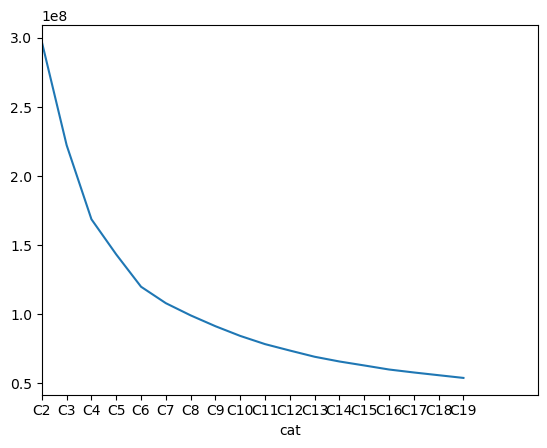

In [ ]:
wcss.plot(xlim=(0,20))

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# 生成随机数据
np.random.seed(42)
data = np.random.rand(100, 12)

# 计算层次聚类
Z = linkage(data, method='ward')

# 使用不同的max_d进行分类
max_d1 = 2.0
max_d2 = 2.5

clusters1 = fcluster(Z, max_d1, criterion='distance')
clusters2 = fcluster(Z, max_d2, criterion='distance')

# 分析合并过程
from collections import defaultdict

# 获取每个簇中的样本索引
def get_cluster_dict(clusters):
    cluster_dict = defaultdict(list)
    for idx, cluster_id in enumerate(clusters):
        cluster_dict[cluster_id].append(idx)
    return cluster_dict

cluster_dict1 = get_cluster_dict(clusters1)
cluster_dict2 = get_cluster_dict(clusters2)

# 打印每个簇中的样本索引
print("Clusters for max_d1:")
for cluster_id, indices in cluster_dict1.items():
    print(f"Cluster {cluster_id}: {indices}")

print("\nClusters for max_d2:")
for cluster_id, indices in cluster_dict2.items():
    print(f"Cluster {cluster_id}: {indices}")

# 分析高等级分类包含的低等级分类
def find_subclusters(cluster_dict1, cluster_dict2):
    result = defaultdict(list)
    for cluster_id2, indices2 in cluster_dict2.items():
        subclusters = set()
        for idx in indices2:
            for cluster_id1, indices1 in cluster_dict1.items():
                if idx in indices1:
                    subclusters.add(cluster_id1)
        result[cluster_id2] = list(subclusters)
    return result

subclusters = find_subclusters(cluster_dict1, cluster_dict2)

print("\nHigh level clusters and their low level subclusters:")
for cluster_id2, subclusters in subclusters.items():
    print(f"High level cluster {cluster_id2} contains low level clusters: {subclusters}")


Clusters for max_d1:
Cluster 9: [0, 3, 5, 50, 53, 59, 70, 86]
Cluster 3: [1, 24, 28, 40, 68, 69, 73, 81, 87, 99]
Cluster 6: [2, 31, 58, 91]
Cluster 10: [4, 30, 44, 84, 85, 98]
Cluster 13: [6, 14, 22, 26, 37, 43, 46, 67, 94, 97]
Cluster 4: [7, 9, 11, 77]
Cluster 7: [8, 35, 38, 39, 55, 64, 71, 78, 80]
Cluster 8: [10, 13, 20, 33, 36, 65, 82]
Cluster 12: [12, 15, 17, 41, 49, 51, 52, 56, 75, 89]
Cluster 5: [16, 32, 45, 47, 62, 66]
Cluster 11: [18, 19, 23, 27, 29, 57, 63]
Cluster 2: [21, 25, 42, 48, 72, 74, 88, 93]
Cluster 1: [34, 54, 60, 61, 76, 79, 83, 90, 92, 95, 96]

Clusters for max_d2:
Cluster 5: [0, 3, 5, 10, 13, 20, 33, 36, 50, 53, 59, 65, 70, 82, 86]
Cluster 3: [1, 7, 9, 11, 16, 24, 28, 32, 40, 45, 47, 62, 66, 68, 69, 73, 77, 81, 87, 99]
Cluster 4: [2, 8, 31, 35, 38, 39, 55, 58, 64, 71, 78, 80, 91]
Cluster 6: [4, 18, 19, 23, 27, 29, 30, 44, 57, 63, 84, 85, 98]
Cluster 8: [6, 14, 22, 26, 37, 43, 46, 67, 94, 97]
Cluster 7: [12, 15, 17, 41, 49, 51, 52, 56, 75, 89]
Cluster 2: [21, 25, 4

In [22]:
clusters

array([ 9,  3,  6,  9, 10,  9, 13,  4,  7,  4,  8,  4, 12,  8, 13, 12,  5,
       12, 11, 11,  8,  2, 13, 11,  3,  2, 13, 11,  3, 11, 10,  6,  5,  8,
        1,  7,  8, 13,  7,  7,  3, 12,  2, 13, 10,  5, 13,  5,  2, 12,  9,
       12, 12,  9,  1,  7, 12, 11,  6,  9,  1,  1,  5, 11,  7,  8,  5, 13,
        3,  3,  9,  7,  2,  3,  2, 12,  1,  4,  7,  1,  7,  3,  8,  1, 10,
       10,  9,  3,  2, 12,  1,  6,  1,  2, 13,  1,  1, 13, 10,  3],
      dtype=int32)

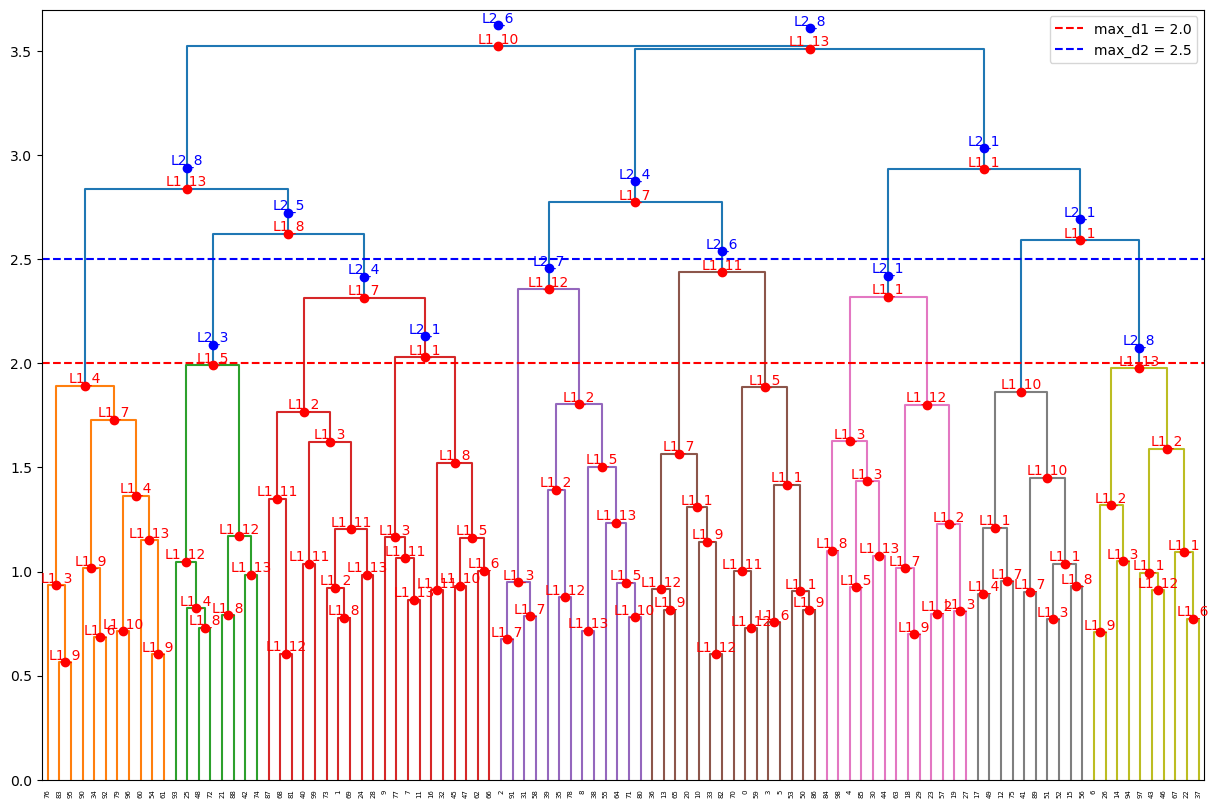


High level clusters and their low level subclusters:
High level cluster 5 contains low level clusters: [8, 9]
High level cluster 3 contains low level clusters: [3, 4, 5]
High level cluster 4 contains low level clusters: [6, 7]
High level cluster 6 contains low level clusters: [10, 11]
High level cluster 8 contains low level clusters: [13]
High level cluster 7 contains low level clusters: [12]
High level cluster 2 contains low level clusters: [2]
High level cluster 1 contains low level clusters: [1]


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from collections import defaultdict

# 生成随机数据
np.random.seed(42)
data = np.random.rand(100, 12)

# 计算层次聚类
Z = linkage(data, method='ward')

# 使用不同的max_d进行分类
max_d1 = 2.0
max_d2 = 2.5

clusters1 = fcluster(Z, max_d1, criterion='distance')
clusters2 = fcluster(Z, max_d2, criterion='distance')

# 获取每个簇中的样本索引
def get_cluster_dict(clusters):
    cluster_dict = defaultdict(list)
    for idx, cluster_id in enumerate(clusters):
        cluster_dict[cluster_id].append(idx)
    return cluster_dict

cluster_dict1 = get_cluster_dict(clusters1)
cluster_dict2 = get_cluster_dict(clusters2)

# 分析高等级分类包含的低等级分类
def find_subclusters(cluster_dict1, cluster_dict2):
    result = defaultdict(list)
    for cluster_id2, indices2 in cluster_dict2.items():
        subclusters = set()
        for idx in indices2:
            for cluster_id1, indices1 in cluster_dict1.items():
                if idx in indices1:
                    subclusters.add(cluster_id1)
        result[cluster_id2] = list(subclusters)
    return result

subclusters = find_subclusters(cluster_dict1, cluster_dict2)

# 绘制树状图并添加不同的剪切平面
plt.figure(figsize=(15, 10))
dendrogram(Z, color_threshold=max_d2)
plt.axhline(y=max_d1, color='r', linestyle='--', label=f'max_d1 = {max_d1}')
plt.axhline(y=max_d2, color='b', linestyle='--', label=f'max_d2 = {max_d2}')
plt.legend()

# 标记每个簇的标签
def plot_labels(clusters, Z, ax, label_color, label_prefix, yoffset=0., threshold=0):
    labels = {i: f'{label_prefix}{cid}' for i, cid in enumerate(clusters)}
    dend = dendrogram(Z, color_threshold=max_d2, no_plot=True)
    icoord = np.array(dend['icoord'])
    dcoord = np.array(dend['dcoord'])
    plt.sca(ax)
    for i, d in enumerate(dcoord):
        x = 0.5 * sum(icoord[i, 1:3])
        y = d[1] + yoffset
        if y<threshold: continue
        cluster_id = clusters[dend['leaves'][i]]
        plt.plot(x, y, 'o', color=label_color)
        plt.text(x, y, f'{labels[i]}', ha='center', va='bottom', color=label_color)

ax = plt.gca()
plot_labels(clusters1, Z, ax, 'red', 'L1_', threshold=0)
plot_labels(clusters2, Z, ax, 'blue', 'L2_', 0.1, max_d1)

plt.show()

# 打印高等级分类及其包含的低等级分类
print("\nHigh level clusters and their low level subclusters:")
for cluster_id2, subclusters in subclusters.items():
    print(f"High level cluster {cluster_id2} contains low level clusters: {subclusters}")
